In [1]:
#=
ビームデータがないwaferについて，対称なwaferにミラーリングしてビームデータを採用するプログラムに変更
ビームを対称にミラーリングするプログラム
ミラーリングしてからビームをシンメトライズし，FWHMを計算する
大枠はできてる
=#
using Pkg
Pkg.activate("/Users/yusuke/program/julia_module/MyPackage")
using MyPackage

using Healpix
using Plots
using NPZ
using LinearAlgebra
using LsqFit
using StatsBase
using BenchmarkTools
using PyCall
using TickTock
using Base.Threads
using StatsPlots
using PyPlot
using DSP
using FFTW
using Formatting
gr()

hp =  pyimport("healpy")
np = pyimport("numpy")
sns = pyimport("seaborn")
plt = pyimport("matplotlib.pyplot")
sp = pyimport("scipy.optimize")
pd = pyimport("pandas")
glob = pyimport("glob")
re = pyimport("re")
os = pyimport("os")
nth = nthreads()# for parallerize

@inline function MultiTrack_calculation(
    NSIDE::Integer,
    start::Integer,
    stop::Integer,
    smp_rate::Integer,
    dθ::Array,
    dφ::Array,
)

    loop = ((stop - start) * smp_rate) + 1

    #println("time=",loop)
    res = Resolution(NSIDE)

    α = 45(π / 180)
    β = 50(π / 180)
    orbit3D = zeros(Float64, loop, 3)
    orbit2D = zeros(Float64, loop, 2)
    dif3D = zeros(Float64, loop-1, 3)
    dif2D = zeros(Float64, loop-1, 2)
    theta_axis3D = zeros(Float64, loop, 3)

    theta_axis = zeros(Float64, loop, 2)
    sky_axis = zeros(Float64, loop, 3)

    pix = zeros(Int64, loop, length(dθ))
    psi_i = zeros(Float64, loop, length(dθ))
    cb = cos(β)
    sb = sin(β)
    ca = cos(α)
    sa = sin(α)
    #println("Start track calculation!")

    for j in eachindex(dθ)
        #println("j=", j)
        #origin =[cos(dθ[j]) * cos(dφ[j]); cos(dθ[j]) * sin(dφ[j]); sin(dθ[j])]
        #=
        origin = [
        cosd(dθ[j]) -sind(dθ[j]) 0
        sind(dθ[j])*cosd(dφ[j]) cosd(dθ[j])*cosd(dφ[j])  -sind(dφ[j])
        sind(dθ[j])*sind(dφ[j]) cosd(dθ[j])*sind(dφ[j])  cosd(dφ[j])
        ]*[1;0;0]
        =#
        origin = [cosd(dθ[j]); sind(dθ[j])cosd(dφ[j]); sind(dθ[j])sind(dφ[j])]

        @inbounds @threads for i in 1:loop
            t = start + (i-1)/smp_rate

            ωₐt = ((2π / 60) / 192.348)t
            ωᵦt = (0.05π / 30)t
            ωᵣt = (2π)t / (60 * 60 * 24 * 365)
            cwb = cos(ωᵦt)
            swb = sin(ωᵦt)
            cwa = cos(ωₐt)
            swa = sin(ωₐt)
            cwr = cos(ωᵣt)
            swr = sin(ωᵣt)

            rot_spin = [
                cb -sb 0
                sb*cwb cb*cwb -swb
                sb*swb cb*swb cwb
            ]
            vec_1 = @views rot_spin * origin

            rot_prec = [
                ca -sa 0
                sa*cwa ca*cwa -swa
                sa*swa ca*swa cwa
            ]
            vec_2 = @views rot_prec * vec_1

            rot_sun = [
                cwr -swr 0
                swr cwr 0
                0 0 1
            ]
            vec_3 = @views rot_sun * vec_2

            orbit3D[i, 1] = vec_3[1]
            orbit3D[i, 2] = vec_3[2]
            orbit3D[i, 3] = vec_3[3]

            ang = @views vec2ang(
                orbit3D[i, 1],
                orbit3D[i, 2],
                orbit3D[i, 3],
            )

            orbit2D[i, 1] = ang[1]
            orbit2D[i, 2] = ang[2]

            theta_axis[i, 1] = orbit2D[i, 1] + (π / 180) * 1e-7

            vec = @views ang2vec(theta_axis[i, 1], orbit2D[i, 2])
            sky_axis[i, 1] = vec[1] - orbit3D[i, 1]
            sky_axis[i, 2] = vec[2] - orbit3D[i, 2]
            sky_axis[i, 3] = vec[3] - orbit3D[i, 3]
            pix[i, j] = ang2pix(m, orbit2D[i, 1], orbit2D[i, 2])
        end

        @inbounds @threads for i in 1:loop-1
            dif3D[i, 1] = orbit3D[i+1, 1] - orbit3D[i, 1]
            dif3D[i, 2] = orbit3D[i+1, 2] - orbit3D[i, 2]
            dif3D[i, 3] = orbit3D[i+1, 3] - orbit3D[i, 3]
            dif2D[i, 1] = orbit2D[i+1, 1] - orbit2D[i, 1]
            dif2D[i, 2] = orbit2D[i+1, 2] - orbit2D[i, 2]

            Vvec = @views dif3D[i, :]
            nvec = @views sky_axis[i, :]
            inner = dot(Vvec, nvec)
            L_dif =
                √(dif3D[i, 1]^2 + dif3D[i, 2]^2 + dif3D[i, 3]^2)
            L_axis = √(
                sky_axis[i, 1]^2 +
                sky_axis[i, 2]^2 +
                sky_axis[i, 3]^2,
            )

            cos_psi = inner / (L_dif * L_axis)

            if dif2D[i, 2] > π
                dif2D[i, 2] = dif2D[i, 2] - 2π
            end
            if dif2D[i, 2] < -π
                dif2D[i, 2] = dif2D[i, 2] + 2π
            end

            judge = sign(-dif2D[i, 2])
            psi_i[i, j] = acos(cos_psi) * judge
        end
    end
    return pix, psi_i
end


function get_psi_and_pix(
    NSIDE::Integer,
    times::Integer,
    smp_rate::Integer,
    dθ::Array,
    dφ::Array,
)

    split_num = 6
    month = Int64(times/split_num)
    Cross = zeros(Float64, (2,4, NPIX))
    hit_pix = zeros(Int64, NPIX)
    theta_line_pix = Int64[]
    theta_line_psi = Float64[]

    Begin = 0
    
    deg = 90(π/180)
    dphi = 20(π/180)

    for i = 1:split_num
        println("process=", i, "/", split_num)
        stop = i*month
        PIX, PSI_i = MultiTrack_calculation(NSIDE, Begin, stop, smp_rate, dθ, dφ)
        loop_times = length(PSI_i)
        
        #println("Start reconstruct!")
        #bore_pix = @views PIX
        #psi_i = @views PSI_i
        
        pix_pi2 = hp.pix2ang(NSIDE, PIX)[2]
    
        for k in 1:loop_times
            bore = PIX[k]
            psi = PSI_i[k]
            TIME = Begin + (k-1)/smp_rate
            
            if pix_pi2[k] < deg + dphi
                if pix_pi2[k] > deg - dphi
                    push!(theta_line_pix, bore)
                    push!(theta_line_psi, psi)
                end
            end        
            hit_pix[bore] += 1
            Cross[1,1,bore] += sin(psi)
            Cross[2,1,bore] += cos(psi)
            Cross[1,2,bore] += sin(2psi)
            Cross[2,2,bore] += cos(2psi)
            Cross[1,3,bore] += sin(3psi)
            Cross[2,3,bore] += cos(3psi)
            Cross[1,4,bore] += sin(4psi)
            Cross[2,4,bore] += cos(4psi)
        end
        Begin = stop + 1
    end
    link1 = (Cross[1,1,:]./hit_pix).^2 .+ (Cross[2,1,:]./hit_pix).^2
    link2 = (Cross[1,2,:]./hit_pix).^2 .+ (Cross[2,2,:]./hit_pix).^2
    link3 = (Cross[1,3,:]./hit_pix).^2 .+ (Cross[2,3,:]./hit_pix).^2
    link4 = (Cross[1,4,:]./hit_pix).^2 .+ (Cross[2,4,:]./hit_pix).^2
    CrossLinks = [link1,link2,link3,link4]    
    return hit_pix, theta_line_pix, theta_line_psi, CrossLinks
end


function Cross_link_certain_direction(
    NSIDE::Integer,
    times::Integer,
    smp_rate::Integer,
    dθ::Array,
    dφ::Array,
)
    split_num = 6
    month = Int64(times/split_num)
    hit_pix = zeros(Int64, NPIX)
    Cross = zeros(Float64, (2,4, NPIX))
    Begin = 0

    for i = 1:split_num
        println("process=", i, "/", split_num)
        stop = i*month
        
        PIX, PSI_i = MultiTrack_calculation(NSIDE, Begin, stop, smp_rate, dθ, dφ)
        loop_times = length(PSI_i)
        #bore_pix = @views PIX
        #psi_i = @views PSI_i
        #println(hit_pix)

        for k in 1:loop_times
            bore = PIX[k]
            #println(bore)
            psi = PSI_i[k]
            TIME = Begin + (k-1)/smp_rate
        
            hit_pix[bore] += 1
            Cross[1,1,bore] += sin(psi)
            Cross[2,1,bore] += cos(psi)
            Cross[1,2,bore] += sin(2psi)
            Cross[2,2,bore] += cos(2psi)
            Cross[1,3,bore] += sin(3psi)
            Cross[2,3,bore] += cos(3psi)
            Cross[1,4,bore] += sin(4psi)
            Cross[2,4,bore] += cos(4psi)
        end
        Begin = stop + 1
    end
    link1 = (Cross[1,1,:]./hit_pix).^2 .+ (Cross[2,1,:]./hit_pix).^2
    link2 = (Cross[1,2,:]./hit_pix).^2 .+ (Cross[2,2,:]./hit_pix).^2
    link3 = (Cross[1,3,:]./hit_pix).^2 .+ (Cross[2,3,:]./hit_pix).^2
    link4 = (Cross[1,4,:]./hit_pix).^2 .+ (Cross[2,4,:]./hit_pix).^2
    CrossLinks = [link1,link2,link3,link4]
    return hit_pix, CrossLinks
end


function hit_map(NSIDE, pix)
    NPIX = nside2npix(NSIDE)
    hit_pix = zeros(Int64, NPIX)
    @threads for i = 1:length(pix)
        hit_pix[pix[i]] += 1
    end
    return hit_pix
end

function flip(pix)
    new_pix = 0
    if pix == 0
        new_pix = 2
    end
    if pix == 2
        new_pix = 0
    end
    if pix == 3
        new_pix = 5
    end
    if pix == 5
        new_pix = 3
    end
    if pix == 6
        new_pix = 8
    end
    if pix == 8
        new_pix = 6
    end
    if pix == 1
        new_pix = 1
    end
    if pix == 4
        new_pix = 4
    end
    if pix == 7
        new_pix = 7
    end
    return new_pix
end


function flip16(n)
    det = Vector(0:1:35)
    det_pix = np.reshape(det, [6,6])
    inv_det = [det_pix[:,6] det_pix[:,5] det_pix[:,4] det_pix[:,3] det_pix[:,2] det_pix[:,1] ]
    idx = np.where(det_pix .== n)
    pixel = inv_det[idx[1][1]+1, idx[2][1]+1]
    return pixel
end

function waferpix2sight(wafer_array, pixel_array)
    loop = length(wafer_array)
    Theta = zeros(loop)
    Phi = zeros(loop)
    beam_path = []
    
    for i in 1:loop
        wafer = wafer_array[i]
        pixel = pixel_array[i]
        switch = 0
        if wafer == 0
            wafer = 3
            pixel = flip(pixel)
            switch += 1
        end
        if wafer == 4
            wafer = 7
            pixel = flip(pixel)
            switch += 1
        end
        
        if wafer == 3 || wafer == 7
            df = pd.read_csv("/Users/yusuke/program/LiteBIRD_sim/beam_study/20200727_pointing_32mm.csv")
        end
        if wafer == 1 || wafer == 5 || wafer == 2 || wafer == 6
            df = pd.read_csv("/Users/yusuke/program/LiteBIRD_sim/beam_study/20200727_pointing_16mm.csv")
        end
        index = np.where((df["wafer"] == wafer) & (df["pixel"] == pixel))[1] .+1
        
        param = df.loc[index[1]]
        theta = param[5]
        phi = param[6]
        
        if wafer == 1
            wafer = 2
            pixel = flip16(pixel)
        end
        if wafer == 5
            wafer = 6
            pixel = flip16(pixel)
        end
        
        index = np.where((df["wafer"] == wafer) & (df["pixel"] == pixel))[1] .+1
        param = df.loc[index[1]]
        name = split(param[1], "Hz")
        name = split(name[1], "_")
        xy_position = name[1]*"_"*name[2]
        
        push!(beam_path, glob.glob("/Users/yusuke/program/LiteBIRD_sim/beam_study/beam_data/beam_data_npz/" * xy_position * "*tp.npz"))
        
        if switch == 0
            if wafer != 0 || wafer != 4
                phi = 180-phi
            end
        end
        Theta[i] = theta
        Phi[i] = phi
    end
    return Theta, Phi, beam_path
end
    

function dist_psi(pixnmb)
    index = np.where(theta_line_pix .== phi90pix[pixnmb])[1] .+1
    psi_in_ipix = zeros(length(index))
    for i in 1:length(index)
        psi_in_ipix[i] = theta_line_psi[index[i]] 
    end
    ddeg = np.deg2rad(0.36)
    ang = round.(np.rad2deg(hp.pix2ang(NSIDE,phi90pix[pixnmb])), sigdigits=3)
    
    println("pix=",ang)

    copol = np.reshape(data["copol"], [N, N])
    copol_sym = MyPackage.rot_beam(psi_in_ipix, copol)

    edge = -180:3:180
    psi_dist = fit(Histogram, np.rad2deg(psi_in_ipix), edge)

    Plots.plot(psi_dist,
        title = "ψᵢ distribution ",
        xlabel="deg",
        label = format("(θ,φ)=({},{})", ang[1], ang[2]),
        seriestype = :step,
        fmt=:png,
    )
end

@. gaussian(x, p) = p[1] * exp(-(1/2)*((x/p[2])^2))


function beam_draw(beam_path, pix_nmb, Wafer, Pixel)
    #pix_nmbは0~100まで
    data = npzread(beam_path)
    index = np.where(theta_line_pix .== phi90pix[pix_nmb])[1] .+1
    
    psi_in_ipix = zeros(length(index))

    @threads for i in eachindex(index)
    psi_in_ipix[i] = theta_line_psi[index[i]] 
    end

    N = 1001
    b_phi = np.deg2rad(np.reshape(data["phi"], [N, N]))
    b_theta = np.deg2rad(np.reshape(data["theta"], [N, N]))
    X = b_theta .* cos.( b_phi )
    Y = b_theta .* sin.( b_phi )
    copol = np.reshape(data["copol"], [N, N])
    copol_sym = MyPackage.rot_beam(psi_in_ipix, copol)
    
    dataname = split(split(beam_path, "/")[end], "_")[3]
    #dataname2 = split(split(beam_path[1][2], "/")[end], "_")[3]
    #dataname3 = split(split(beam_path[1][3], "/")[end], "_")[3]
    #println(Wafer)
    
    figure(111)
    plt.title(format("Original {} (W, P)=({}, {}) ", dataname, Wafer[1], Pixel[1]))
    pcolormesh(X, Y, 10log10.(copol), cmap = "jet" )
    pp = plt.colorbar( orientation ="vertical")
    plt.grid()
    #plt.savefig(format("./Original_{}_WP_{}_{}.png", dataname, Wafer[1], Pixel[1]))


    figure(222)
    plt.title(format("Symmetrized {} (W, P)=({}, {}) ", dataname, Wafer[1], Pixel[1]))
    pcolormesh(X, Y, 10log10.(copol_sym), cmap = "jet" )
    pp = plt.colorbar( orientation ="vertical")
    plt.grid()
    #plt.savefig(format("./Symmetrized_{}_WP_{}_{}.png", dataname, Wafer[1], Pixel[1]))
end

function dist_FWHM(beam_path, theta_line_pix, phi90pix)
    ddeg = np.deg2rad(0.36)
    beam_nmb = length(beam_path)
    
    FWHM = zeros(length(phi90pix), 4)
    FWHM_dist = zeros(400, beam_nmb)
    #p0 = [50435, 0.00487]
    
    idx1 = [1, 125, 250, 375]
    idx2 = idx1 .+ 500
    
    for k in 1:beam_nmb
        
        data = npzread(beam_path[k])
        println(beam_path[k])
        b_phi = np.deg2rad(np.reshape(data["phi"], [1001, 1001]))
        b_theta = np.deg2rad(np.reshape(data["theta"], [1001, 1001]))
        copol = np.reshape(data["copol"], [1001, 1001])
        xdata = @views [reverse(b_theta[:,1]) ; -b_theta[:,500]]
        for i in eachindex(phi90pix)
            if i%10 == 0
                println(i)
            end
        
            index = np.where(theta_line_pix .== phi90pix[i])[1] .+1
    
            psi_in_ipix = zeros(length(index))
            @threads for i in eachindex(index)
                psi_in_ipix[i] = theta_line_psi[index[i]] 
            end
        
            if length(psi_in_ipix) != 0
                copol_sym = MyPackage.rot_beam(psi_in_ipix, copol)

                @threads for j in 1:4
                    ydata = @views [reverse(copol_sym[:,idx1[j]])  ;copol_sym[:,idx2[j]]]
                    p0 = [findmax(ydata)[1], 0.01]
                    Fit = curve_fit(gaussian, xdata, ydata, p0)
                    FWHM[i,j] = 60*2*√(2*log(2))* (Fit.param[2])*(180/π)
                end
            end
        end

        fwhm_dist = np.ravel(FWHM)
        #println(length(fwhm_dist))
        #println(fwhm_dist)
        
        @threads for i in eachindex(fwhm_dist)
            FWHM_dist[i,k] = fwhm_dist[i]
        end
    end
    return FWHM_dist
end

 Activating environment at `~/program/julia_module/MyPackage/Project.toml`


dist_FWHM (generic function with 1 method)

In [2]:
const NSIDE = 128
const NPIX = nside2npix(NSIDE)
const m = Map{Float64,RingOrder}(NSIDE)
const day = 60 * 60 * 24
const year = day * 365
smp_rate = 5
times = year
prec1 = 60*60*3
println("SR=", smp_rate)

WFFP = Int[]
PXFP = Int[]
for i in 0:7
    nmb = 35
    if i == 0 || i == 3 || i == 4 || i == 7
        nmb = 8
    end
    for j in 0:nmb
        push!(WFFP, i)
        push!(PXFP, j)
    end
end

div = 100
elev = np.linspace(0, π, div)
azim = ones(div) .* π / 2
phi90pix = hp.ang2pix(NSIDE, elev, azim) .+1

Wafer = [4]
Pixel = [3]

SR=5


1-element Array{Int64,1}:
 3

┌ Warning: `getindex(o::PyObject, s::AbstractString)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o."s"` instead of `o["s"]`.
│   caller = waferpix2sight(::Array{Int64,1}, ::Array{Int64,1}) at In[1]:367
└ @ Main ./In[1]:367
┌ Warning: `getindex(o::PyObject, s::AbstractString)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o."s"` instead of `o["s"]`.
│   caller = waferpix2sight(::Array{Int64,1}, ::Array{Int64,1}) at In[1]:367
└ @ Main ./In[1]:367
┌ Warning: `getindex(o::PyObject, i::Integer)` is deprecated, use `get(o, i - 1)` instead.
│   caller = waferpix2sight(::Array{Int64,1}, ::Array{Int64,1}) at In[1]:369
└ @ Main ./In[1]:369
┌ Warning: `getindex(o::PyObject, i::Integer)` is deprecated, use `get(o, i - 1)` instead.
│   caller = waferpix2sight(::Array{Int64,1}, ::Array{Int64,1}) at In[1]:370
└ @ Main ./In[1]:370
┌ Warning: `getindex(o::PyObject, i::Integer)` is deprecat

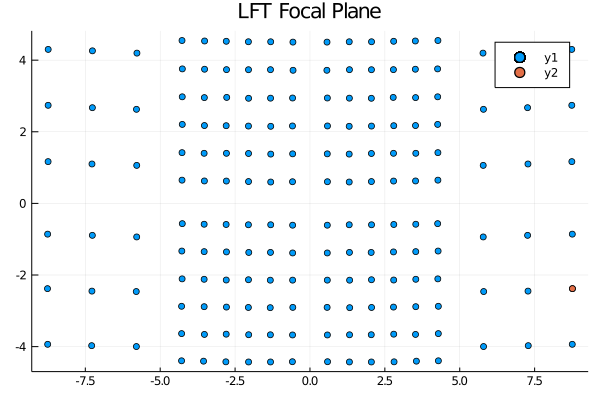

In [3]:
th, ph, bpath1 = waferpix2sight(WFFP, PXFP)

th1, ph1, bpath1 = waferpix2sight(Wafer, Pixel)
x1 = -th1 .* cosd.(ph1)
y1 = th1 .* sind.(ph1)

x = -th .* cosd.(ph)
y = th .* sind.(ph)
Plots.plot(x, y, st=:scatter, title="LFT Focal Plane", fmt=:png)
Plots.plot!(x1, y1, st=:scatter, title="LFT Focal Plane", fmt=:png)

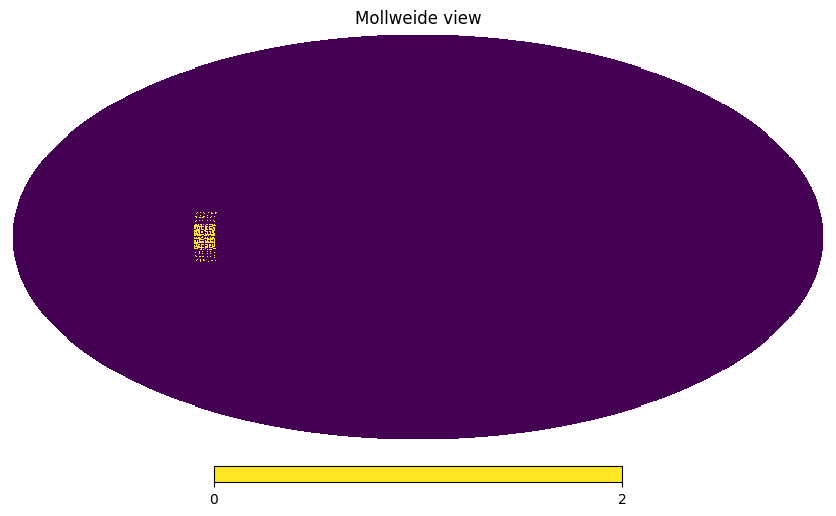

2×180 Array{Int64,2}:
 113026  110978  107906  113028  110468  …  85899  82827  88462  85901  83342
 113026  109954  107906  112516  110468     84875  82827  87949  85390  82829

In [4]:
#tick()
th, ph, bpath = waferpix2sight(WFFP, PXFP)
pix, psi_i= MultiTrack_calculation(NSIDE, 0, 1, 1, th, ph .+90)
I_lu = hit_map(NSIDE, pix)
#Plots.plot(MyPackage.gen_map(NSIDE, I_lu) ,c=:jet, fmt=:png)

hp.mollview(I_lu, norm="hist")
pix

In [5]:
tick()
dth, dph, beam_path = waferpix2sight(Wafer, Pixel)
hit_pix, theta_line_pix, theta_line_psi, CrossLinks = get_psi_and_pix(NSIDE, times, smp_rate, dth, dph .+90)

┌ Info:  started timer at: 2020-08-31T19:37:22.22
└ @ TickTock /Users/yusuke/.julia/packages/TickTock/3F6de/src/TickTock.jl:32


process=1/6
process=2/6
process=3/6
process=4/6
process=5/6
process=6/6


([1378, 1381, 1374, 1381, 1394, 1369, 1353, 1407, 1385, 1367  …  1364, 1403, 1374, 1362, 1375, 1389, 1383, 1395, 1394, 1397], [113547, 113036, 112523, 112523, 112523, 112523, 112523, 112523, 112523, 112523  …  120, 120, 120, 91, 91, 91, 92, 92, 92, 92], [-3.0406632715009603, -3.041211365431762, -3.0417592389751875, -3.0423068423922603, -3.042854352237471, -3.0434016396835464, -3.043948710469678, -3.0444956080767724, -3.0450423442047163, -3.0455888192348626  …  -2.759484757508973, -2.7526171698023534, -2.7454802650278567, -2.7380594209892717, -2.7303389949844243, -2.7223022771533154, -2.713931373265463, -2.705207139413998, -2.6961090482292716, -2.6866151135285996], [[0.0002865034399379072, 0.0002524171267089825, 0.0003233829300767325, 0.0004273167480324262, 0.00042470345818295335, 0.0004534876836644937, 0.0007397825676237207, 0.000621169375967649, 0.00018147669598907455, 0.0005380891981895347  …  0.0006171194353219824, 0.000781832617102158, 0.00042499748522849956, 0.0004656665976881006,

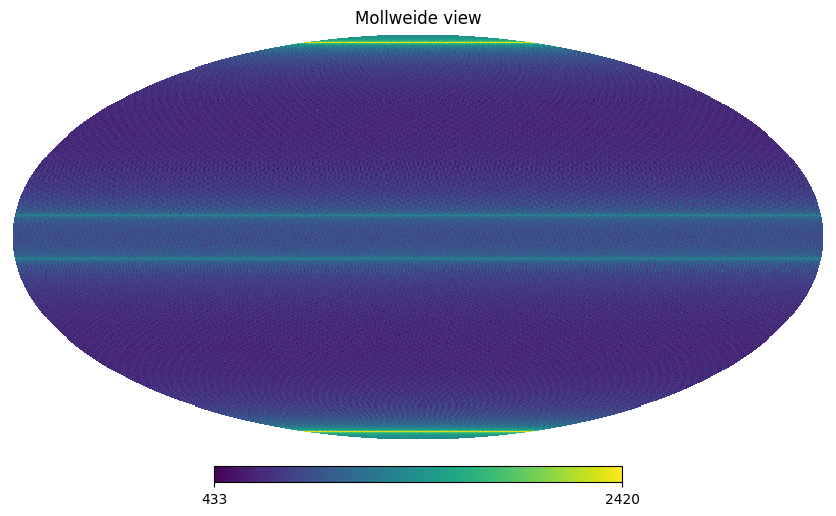

In [6]:
#I_lu = hit_map(NSIDE, hit_pix)
#Plots.plot(MyPackage.gen_map(NSIDE, I_lu) ,c=:jet, fmt=:png)
hp.mollview(hit_pix, norm="None")

In [7]:
#=
data = npzread("/Users/yusuke/program/LiteBIRD_sim/beam_study/beam_data/beam_data_npz/m12_m92_140G_000deg_tp.npz")
copol = np.reshape(data["copol"], [N, N])
copol_sym = MyPackage.rot_beam(psi_in_ipix, copol)

cut=30
a = [reverse(copol_sym[1:cut,1])  ;copol_sym[1:cut,501]]
b = [reverse(b_theta[1:cut,1]) ; -b_theta[1:cut,501]]


xdata = b
ydata = a
p0 = [findmax(ydata)[1], 0.01]
Fit = curve_fit(gaussian, xdata, ydata, p0)
println(Fit.param)

gauss = gaussian(xdata, Fit.param)
FWHM = 2*√(2*log(2))*Fit.param[2]
println("FWHM=", np.rad2deg(FWHM)*60)
Plots.plot(xdata, ydata, label = "Symmetrized beam", fmt=:png)
Plots.plot!(xdata, gauss, label = "Fitting")
=#

In [8]:
fwhm = dist_FWHM(beam_path[1], theta_line_pix, phi90pix)

/Users/yusuke/program/LiteBIRD_sim/beam_study/beam_data/beam_data_npz/m189_m52_78.0G_000deg_tp.npz
10
20
30
40
50
60
70
80
90
100
/Users/yusuke/program/LiteBIRD_sim/beam_study/beam_data/beam_data_npz/m189_m52_40.0G_000deg_tp.npz
10
20
30
40
50
60
70
80
90
100
/Users/yusuke/program/LiteBIRD_sim/beam_study/beam_data/beam_data_npz/m189_m52_60.0G_000deg_tp.npz
10
20
30
40
50
60
70
80
90
100


400×3 Array{Float64,2}:
  0.0      0.0      0.0
  0.0      0.0      0.0
  0.0      0.0      0.0
  0.0      0.0      0.0
  0.0      0.0      0.0
  0.0      0.0      0.0
  0.0      0.0      0.0
  0.0      0.0      0.0
 43.649   71.8271  50.9488
 43.6152  72.1692  50.9113
 43.6041  71.7331  50.9021
 43.6384  71.7567  50.9446
 43.6809  71.6731  50.9886
  ⋮                
 43.659   71.7583  50.9632
 43.6304  72.1357  50.9252
 43.5935  71.9615  50.8881
 43.622   71.6331  50.9268
  0.0      0.0      0.0
  0.0      0.0      0.0
  0.0      0.0      0.0
  0.0      0.0      0.0
  0.0      0.0      0.0
  0.0      0.0      0.0
  0.0      0.0      0.0
  0.0      0.0      0.0

In [9]:
FWHM1 = Float64[]
FWHM2 = Float64[]
FWHM3 = Float64[]
for i in 1:400
    if fwhm[i,1] != 0
        push!(FWHM1, fwhm[i,1])
    end
end
for i in 1:400
    if fwhm[i,2] != 0
        push!(FWHM2, fwhm[i,2])
    end
end
for i in 1:400
    if fwhm[i,3] != 0
        push!(FWHM3, fwhm[i,3])
    end
end
tock()

┌ Info:       1523.856597329s: 25 minutes, 23 seconds, 856 milliseconds
└ @ TickTock /Users/yusuke/.julia/packages/TickTock/3F6de/src/TickTock.jl:39


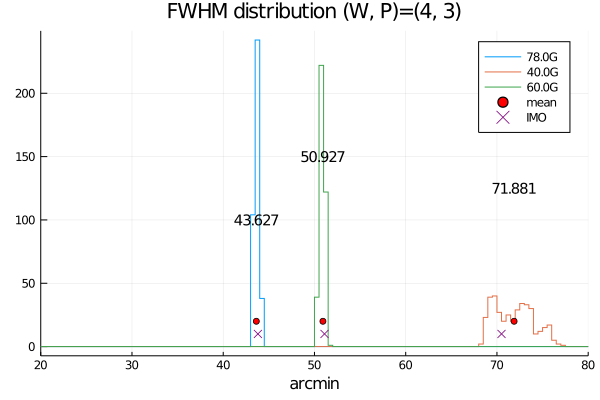

In [16]:
edge = 20:0.5:80
fwhm_dist1 = fit(Histogram, FWHM1, edge)
fwhm_dist2 = fit(Histogram, FWHM2, edge)
fwhm_dist3 = fit(Histogram, FWHM3, edge)
#format("(θ,φ)=({},{})", ang[1], ang[2]),
dataname1 = split(split(beam_path[1][1], "/")[end], "_")[3]
dataname2 = split(split(beam_path[1][2], "/")[end], "_")[3]
dataname3 = split(split(beam_path[1][3], "/")[end], "_")[3]

Plots.plot([fwhm_dist1, fwhm_dist2, fwhm_dist3],
    title = format("FWHM distribution (W, P)=({}, {})", Wafer[1], Pixel[1]),
    xlabel="arcmin",
    label = [dataname1 dataname2 dataname3],
    xlim=(20,80),
    seriestype = :step,
    fmt=:png)

#annotations = ([mean(FWHM1)], [20], Plots.text("this is #3", :left))
#Plots.plot!([mean(FWHM1)], [20], annotations, st=:scatter, label="meam", color=:red)

m1 = mean(FWHM1)
m2 = mean(FWHM2)
m3 = mean(FWHM3)

Plots.plot!([m1], annotations = (m1, 100, Plots.text(format("{}", round(m1, digits=3)), :center, 10)), label=false)
Plots.plot!([m1], [20], st=:scatter, label="mean", color=:red)

Plots.plot!([m2], annotations = (m2, 125, Plots.text(format("{}", round(m2, digits=3)), :center, 10)), label=false)
Plots.plot!([mean(FWHM2)], [20], st=:scatter, label=false, color=:red)

Plots.plot!([m3], annotations = (m3, 150, Plots.text(format("{}", round(m3, digits=3)), :center, 10)), label=false)
Plots.plot!([mean(FWHM3)], [20], st=:scatter, label=false, color=:red)


#red
scatter!([70.5], [10], st=:scatter, label="IMO", color=:purple, marker=:xcross)#40G,32
scatter!([51.1], [10], st=:scatter, label=false, color=:purple, marker=:xcross)#60G,32
scatter!([43.8], [10], st=:scatter, label=false, color=:purple, marker=:xcross)#78G,32

#=
#yellow
scatter!([41.5], [10], st=:scatter, label="IMO", color=:purple, marker=:xcross)#89G,32
scatter!([58.5], [10], st=:scatter, label=false, color=:purple, marker=:xcross)#50G,32
scatter!([47.1], [10], st=:scatter, label=false, color=:purple, marker=:xcross)#68G,32
=#
#=
#green
scatter!([41.6], [10], st=:scatter, label="IMO", color=:purple, marker=:xcross)#68G,16
scatter!([33.0], [10], st=:scatter, label=false, color=:purple, marker=:xcross)#89G,16
scatter!([26.3], [10], st=:scatter, label=false, color=:purple, marker=:xcross)#119G,16
=#

#=
#blue
scatter!([36.9], [10], st=:scatter, label="IMO", color=:purple, marker=:xcross)#78G,16
scatter!([30.2], [10], st=:scatter, label=false, color=:purple, marker=:xcross)#100G,16
scatter!([23.7], [10], st=:scatter, label=false, color=:purple, marker=:xcross)#140G,16
=#


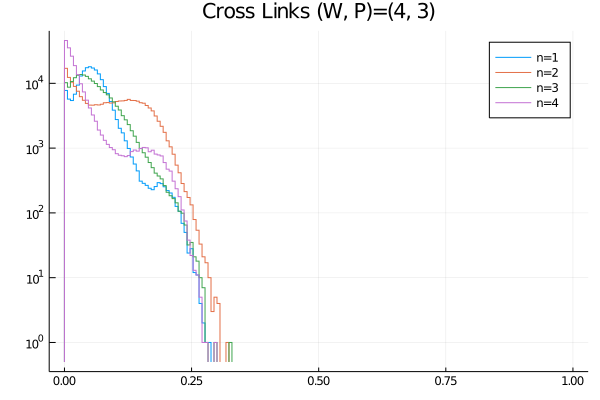

In [11]:
link1 = np.nan_to_num(CrossLinks[1],nan=-0.1)
link2 = np.nan_to_num(CrossLinks[2],nan=-0.1)
link3 = np.nan_to_num(CrossLinks[3],nan=-0.1)
link4 = np.nan_to_num(CrossLinks[4],nan=-0.1)
BINS=170
edge = 0:1/BINS:1
l1 = fit(Histogram, link1, edge)
l2 = fit(Histogram, link2, edge)
l3 = fit(Histogram, link3, edge)
l4 = fit(Histogram, link4, edge)

Plots.plot([l1,l2,l3,l4],
    title = format("Cross Links (W, P)=({}, {})", Wafer[1], Pixel[1]),
    label = ["n=1" "n=2" "n=3" "n=4"],
    seriestype = :step, yaxis=:log, fmt=:png)

24.32103
155.8604


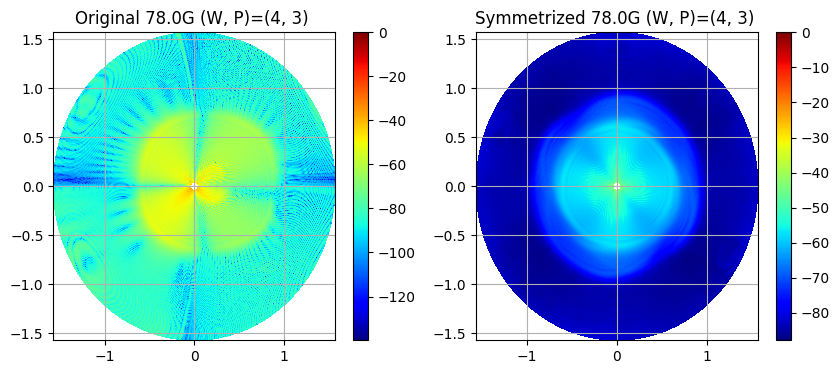

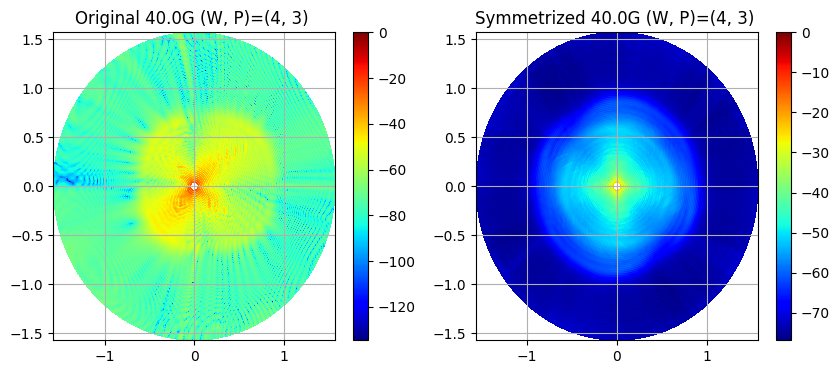

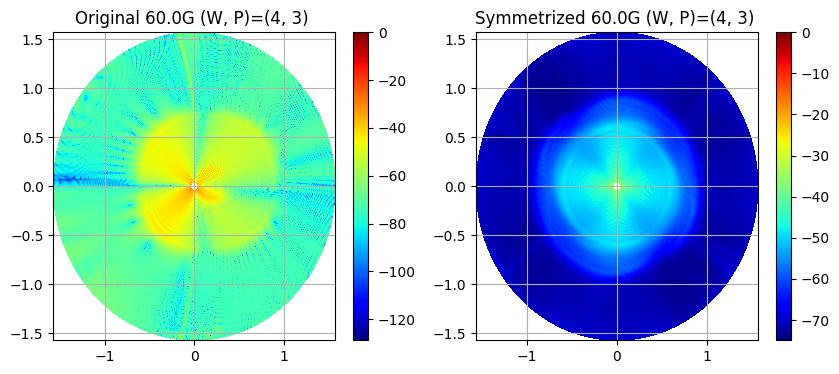

16.9932


In [34]:

function beam_draw(beam_path, pix_nmb, Wafer, Pixel)
    #pix_nmbは0~100まで
    data = npzread(beam_path)
    index = np.where(theta_line_pix .== phi90pix[pix_nmb])[1] .+1
    
    psi_in_ipix = zeros(length(index))

    @threads for i in eachindex(index)
    psi_in_ipix[i] = theta_line_psi[index[i]] 
    end

    N = 1001
    b_phi = np.deg2rad(np.reshape(data["phi"], [N, N]))
    b_theta = np.deg2rad(np.reshape(data["theta"], [N, N]))
    X = b_theta .* cos.( b_phi )
    Y = b_theta .* sin.( b_phi )
    copol = np.reshape(data["copol"], [N, N])
    copol_sym = MyPackage.rot_beam(psi_in_ipix, copol)
    copol_max = maximum(copol)
    copol_sym_max = maximum(copol_sym)
    println(maximum(copol))
    
    dataname = split(split(beam_path, "/")[end], "_")[3]
    #dataname2 = split(split(beam_path[1][2], "/")[end], "_")[3]
    #dataname3 = split(split(beam_path[1][3], "/")[end], "_")[3]
    #println(Wafer)

    fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))

    axL.set_title(format("Original {} (W, P)=({}, {}) ", dataname, Wafer[1], Pixel[1]))
    L = axL.pcolormesh(X, Y, 10log10.(copol./copol_max), cmap = "jet" )
    fig.colorbar(L, ax=axL)
    axL.grid()
    #plt.savefig(format("./Original_{}_WP_{}_{}.png", dataname, Wafer[1], Pixel[1]))

    axR.set_title(format("Symmetrized {} (W, P)=({}, {}) ", dataname, Wafer[1], Pixel[1]))
    R = axR.pcolormesh(X, Y, 10log10.(copol_sym./copol_sym_max), cmap = "jet" )
    fig.colorbar(R, ax=axR)
    #axR.set_colorbar( orientation ="vertical")
    axR.grid()
    #plt.savefig(format("./Symmetrized_{}_WP_{}_{}.png", dataname, Wafer[1], Pixel[1]))
end

for i in 1:3
    beam_draw(beam_path[1][i], 50 , Wafer, Pixel)
end

In [13]:
#savepath = "/Users/yusuke/program/LiteBIRD_sim/beam_study/beam_data/calc_fwhm_dist/"
#np.savez_compressed(savepath * main_name * "_fwhm", data=FWHM_)

In [14]:
#a = npzread(savepath * main_name * "_fwhm" * ".npz")
#a["data"]

In [15]:
function FWHM_plot(FWHM1, FWHM2, FWHM3)
    edge = 20:0.5:80
    fwhm_dist1 = fit(Histogram, FWHM1, edge)
    fwhm_dist2 = fit(Histogram, FWHM2, edge)
    fwhm_dist3 = fit(Histogram, FWHM3, edge)
    #format("(θ,φ)=({},{})", ang[1], ang[2]),
    dataname1 = split(split(beam_path[1][1], "/")[end], "_")[3]
    dataname2 = split(split(beam_path[1][2], "/")[end], "_")[3]
    dataname3 = split(split(beam_path[1][3], "/")[end], "_")[3]

    Plots.plot([fwhm_dist1, fwhm_dist2, fwhm_dist3],
        title = format("FWHM distribution (W, P)=({}, {})", Wafer[1], Pixel[1]),
        xlabel="arcmin",
        label = [dataname1 dataname2 dataname3],
        xlim=(20,80),
        seriestype = :step,
        fmt=:png)

    m1 = mean(FWHM1)
    m2 = mean(FWHM2)
    m3 = mean(FWHM3)

    Plots.plot!([m1], annotations = (m1, 100, Plots.text(format("{}", round(m1, digits=3)), :center, 10)), label=false)
    Plots.plot!([m1], [20], st=:scatter, label="mean", color=:red)

    Plots.plot!([m2], annotations = (m2, 125, Plots.text(format("{}", round(m2, digits=3)), :center, 10)), label=false)
    Plots.plot!([mean(FWHM2)], [20], st=:scatter, label=false, color=:red)

    Plots.plot!([m3], annotations = (m3, 150, Plots.text(format("{}", round(m3, digits=3)), :center, 10)), label=false)
    Plots.plot!([mean(FWHM3)], [20], st=:scatter, label=false, color=:red)
    Plots.savefig("./test.pdf")
end
function CrossLink_plot(CrossLinks)
    link1 = np.nan_to_num(CrossLinks[1],nan=-0.1)
    link2 = np.nan_to_num(CrossLinks[2],nan=-0.1)
    link3 = np.nan_to_num(CrossLinks[3],nan=-0.1)
    link4 = np.nan_to_num(CrossLinks[4],nan=-0.1)
    BINS=170
    edge = 0:1/BINS:1
    l1 = fit(Histogram, link1, edge)
    l2 = fit(Histogram, link2, edge)
    l3 = fit(Histogram, link3, edge)
    l4 = fit(Histogram, link4, edge)
    Plots.plot([l1,l2,l3,l4],
        title = format("Cross Links (W, P)=({}, {})", Wafer[1], Pixel[1]),
        label = ["n=1" "n=2" "n=3" "n=4"],
        seriestype = :step, yaxis=:log, fmt=:PDF)
    Plots.savefig("./test.pdf")
end
    
    
CrossLink_plot(CrossLinks)